### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

### Read and preprocess data 

In [48]:
dateparser = lambda x: pd.datetime.strptime(x, "%d/%m/%Y %H:%M")
df = pd.read_csv("input_series_data.csv", parse_dates=['datetime'], date_parser=dateparser)
df.set_index('datetime', inplace=True)

In [49]:
df.head()

,variable
datetime,
2019-03-01 00:00:00,3601.934438
2019-03-01 00:10:00,3778.383666
2019-03-01 00:20:00,4067.039376
2019-03-01 00:30:00,4220.305584
2019-03-01 00:40:00,4213.950811


### Vizualise data

array([<matplotlib.axes._subplots.AxesSubplot object at 0x10bf854d0>],
      dtype=object)

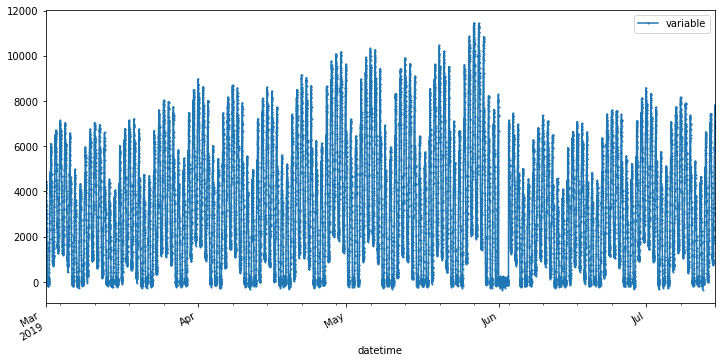

In [53]:
pd.plotting.register_matplotlib_converters()
df.plot(kind='line', subplots=True, figsize=(12,6), style='-o', markersize=1)

### Train model with optimal parameters

In [67]:
## Remove cross validation? takesa lot of time, or just do 2 or 3 (not 15)

In [68]:
def prophet_model(data, horizon_days):
    
    from fbprophet import Prophet
    from sklearn.model_selection import ParameterGrid
    from fbprophet.diagnostics import cross_validation
    
    # define error function
    def mape(true, pred):
        return np.mean(np.abs((true - pred) / true)) * 100
    
    # transform data into prophet format
    idx_name = data.index.name
    data.index.rename('ds', inplace=True)
    data.rename({data.columns[0]: 'y'}, axis=1, inplace=True)
    
    # define grid to do grid search
    params_grid = {'growth': ['linear'],
                   'seasonality_prior_scale': [5, 10, 30],
                   'changepoint_range': [0.8, 0.9],
                   'changepoint_prior_scale': [0.05, 0.1, 0.5],
                   'n_changepoints': [10, 30],
                   'seasonality_mode': ['additive', 'multiplicative']
                  }
    grid = ParameterGrid(params_grid)

    # fit Prophet and evaluate score
    list_score = []
    for p in grid:
        m=Prophet(**p)
        m.fit(data.reset_index())
        cv = cross_validation(m, horizon=horizon_days)
        p['mape'] = mape(cv.y, cv.yhat)
        list_score.append(p)
    
    # get the parameters from the model that performed better
    best_model = min(list_score, key=lambda x:x['mape'])
    print('MAPE: ', best_model['mape'])
    best_model.pop('mape', None)
    
    # fit model with best parameters
    m = Prophet(**best_model)
    m.fit(data.reset_index())
    
    return m

In [62]:
model = prophet_model(df, horizon_days='30 days')

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 15 forecasts with cutoffs between 2019-04-11 23:50:00 and 2019-11-07 23:50:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 15 forecasts with cutoffs between 2019-04-11 23:50:00 and 2019-11-07 23:50:00


SystemError: <class 'stanfit4anon_model_861b75c6337e237650a61ae58c4385ef_5288179219436652478.PyStanHolder'> returned a result with an error set

In [78]:
df.index.max()

'2019-12-07 23:50:00'

In [77]:
final_datetime = (df.index.max() + timedelta(days=30))
print('End of forecast date:', final_datetime)

TypeError: can only concatenate str (not "datetime.timedelta") to str

In [ ]:
horizon_days = (final_datetime - dfB.index.max()).days
f = '10T'
horizon_period = horizon_days * 24 * 6 # days to 10 minute pediods
future = model_varB.make_future_dataframe(periods=horizon_period, freq=f)

# predict
fcst = model_varB.predict(future)

# plot results
plot_prophet(model_varB, fcst)

# save forecast results
varB_pred = fcst[fcst['ds'] > dfB.index.max()][['ds','yhat']]\
    .rename(columns={'yhat': 'varB'})\
    .set_index('ds')

# create datetime range
fcst_series = pd.date_range(start = df.index.max() + timedelta(minutes=5), end=final_datetime, freq='5T')

# create results dataframe
forecast_varB = pd.DataFrame(fcst_series, columns=['datetime']).set_index('datetime')
forecast_varB['varB'] = varB_pred

# plot forecast
print('============= Forecast results for varB =============')
plot_forecast(df[['varB']], forecast_varB, title='Forecasting varB', m='.')